The objective of this notebook is to try learning a binary classifier from intervals of probabilities and not hard labels (example : $z_i = (x_i, y_i)$ with $y_i = 1$ is a classical case in learning problems, here we want to learn a classifier using $z_i = (x_i, y_i)$ with $y_i = [0.6, 0.76]$

# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.special import rel_entr

from typing import List, Tuple

from warnings import simplefilter
simplefilter(action='ignore')

# Load dataset

In [2]:
df = pd.read_csv("../../data/SynthPara_n1000_p2.csv")
df.head()

,X1,X2,z
0,3.119353,7.100552,B
1,-3.850261,-4.934919,A
2,-4.214494,-7.396423,A
3,3.197394,4.783222,B
4,-4.296943,-4.839382,A


In [3]:
df.shape

(1000, 3)

We have to predictors and one response variable with label A or B (i.e 0 or 1). First let's plot our data to see the decision boundary 

## plot data

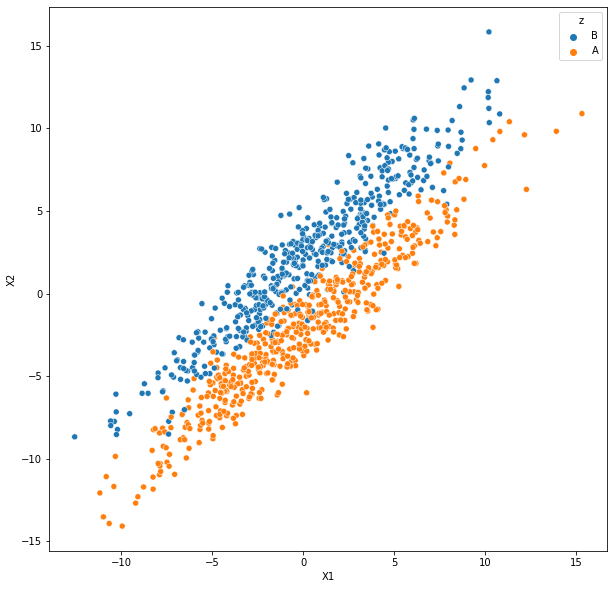

In [4]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="z")
plt.show()

The decision boundary seems to be a linear function

## Add intervals

We first add random intervals of probabilities representing the following probability: $p(Y=A|X=x)$

In [5]:
def transform_to_interval(variable: str) -> np.ndarray:
    """
    Transform a hard label into an interval of probabilities.
    If the label is 0, the created interval will be in the range of
    [0, 0.49], else it will be in the range of [0.5, 1]
    
    Args:
        variable (int): variable to transform
    
    Returns:
        (np.ndarray): created interval 
    """
    if variable == "B":
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.0,
                    high=0.49,
                    size=(2,)
                ),
                decimals=2
            )
        )
    else:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.5,
                    high=1.0,
                    size=(2,)
                ),
                decimals=2
            )
        )
    return interval

In [6]:
df["interval"] = df["z"].apply(transform_to_interval)
df.head()

,X1,X2,z,interval
0,3.119353,7.100552,B,"[0.2, 0.43]"
1,-3.850261,-4.934919,A,"[0.61, 0.8]"
2,-4.214494,-7.396423,A,"[0.8, 0.85]"
3,3.197394,4.783222,B,"[0.09, 0.48]"
4,-4.296943,-4.839382,A,"[0.55, 0.92]"


# Loss function

The objective now is trying to find a loss function applicable on intervals with the following properties: 

Let $\mathcal{L}$ being a loss function, $p_{inf}(Y|X=x)$ the lower bound of our intervals of probabilities, $p_{sup}(Y|X=x)$ the upper bound and $\hat{p}{Y|X=x)$ the predicted probability by a model of Y being A knowing X

We fix the loss function with the following:

- $\mathcal{L}(p_{inf}(Y|X=x), \hat{p}(Y|X=x))$ if $\hat{p}(Y|X=x) \notin [p_{inf}(Y|X=x), p_{sup}(Y|X=x)$ and $\hat{p}(Y|X=x) < p_{inf}(Y|X=x)$

- $0$ if $\hat{p}(Y|X=x) \in [p_{inf}(Y|X=x), p_{sup}(Y|X=x)]$ 

- $\mathcal{L}(p_{sup}(Y|X=x), \hat{p}(Y|X=x))$ if $\hat{p}(Y|X=x) \notin [p_{inf}(Y|X=x), p_{sup}(Y|X=x)$ and $\hat{p}(Y|X=x) > p_{sup}(Y|X=x)$

The Loss function we will use is the Kullback-Leibler divergence given by the formula:

Let $\mathcal{Y}$ being the label space, $p_y(Y=y|X=x)$ the probability that y is the label of X and $q_y(Y=y|X=x)$ the probability predicted by the model of y being the label of X
$$
D_{KL}(p||q) = \sum_{y \in \mathcal{Y}}p_y(Y=y|X=x)\ln(\frac{p_y(Y=y|X=x)}{q(Y=y|X=x)})
$$

In our binary case, $D_{KL}$ is given by this formula:

$$
D_{KL}(p(Y=1|X=x)||q(Y=1|X=x)) = p(Y=1|X=x)\ln(\frac{p(Y=1|X=x)}{q(Y=1|X=x)}) + (1-p(Y=1|X=x))\ln(\frac{1-p(Y=1|X=x)}{1-q(Y=1|X=x)})
$$

This loss function verify the 3 properties we mentionned above

Proof:

Consider a given $q(Y=1|X=x)$, we want to see if we can have $D_{KL}=0$ if $q(Y=1|X=x) \in [p_{inf}(Y=1|X=x), p_{sup}(Y=1|X=x)]$. We note $q(Y=1|X=x)=q$, $p_{inf}(Y=1|X=x) = p_i$, $p_{sup}(Y=1|X=x) = p_s$ and more generally $p(Y=1|X=x) = p$. Let differenciate $D_{KL}$ according to $p$ to see if can have a minimum, what is this minimum and what is the value of $D_{KL}$:

$$
\frac{\partial D_{KL}}{\partial p} = \ln(\frac{p}{q}) - \ln(\frac{1-p}{1-q}) \\
$$
So
$$
\begin{split}
\frac{\partial D_{KL}}{\partial p} = 0 \\
\Leftrightarrow \ln(\frac{p}{q}) = \ln(\frac{1-p}{1-q}) \\
\Leftrightarrow \frac{p}{q} = \frac{1-p}{1-q} \\
\Leftrightarrow p - pq = q - pq \\
\Leftrightarrow p = q \\
\end{split}
$$

We have a minimum for $p=q$, and $p=q \Rightarrow D_{KL} = p\ln(1) + (1-p)\ln(1) = 0$

So if $q \in [p_i, p_s]$ then $D_{KL} = 0$ 

And as $D_{KL}$ is convex, if $q < p_i$ then min $D_{KL} = D_{KL}(p_i || q)$ (same for max $D_{KL}$)

# Apply loss function 

In [7]:
df["label"] = df["z"].apply(lambda x: 1 if x=="A" else 0)
df.head()

,X1,X2,z,interval,label
0,3.119353,7.100552,B,"[0.2, 0.43]",0
1,-3.850261,-4.934919,A,"[0.61, 0.8]",1
2,-4.214494,-7.396423,A,"[0.8, 0.85]",1
3,3.197394,4.783222,B,"[0.09, 0.48]",0
4,-4.296943,-4.839382,A,"[0.55, 0.92]",1


## Get $\hat{p}(Y|X=x)$

To test the loss function, we need to compute $\hat{p}(Y=1|X=x)$. To do this, we train a logistic regression with just one iteration

In [8]:
lr = LogisticRegression(max_iter=1)
lr.fit(df[["X1", "X2"]], df["label"])
df["p_hat"] = lr.predict_proba(df[["X1", "X2"]])[:, 1]
df.head()

,X1,X2,z,interval,label,p_hat
0,3.119353,7.100552,B,"[0.2, 0.43]",0,0.135567
1,-3.850261,-4.934919,A,"[0.61, 0.8]",1,0.791774
2,-4.214494,-7.396423,A,"[0.8, 0.85]",1,0.876670
3,3.197394,4.783222,B,"[0.09, 0.48]",0,0.218552
4,-4.296943,-4.839382,A,"[0.55, 0.92]",1,0.789656


In [9]:
def add_probability_used(interval, p_hat):
    if p_hat < interval[0]:
        return interval[0]
    elif p_hat > interval[1]:
        return interval[1]
    else:
        return p_hat

In [10]:
df["p"] = df.apply(lambda x: add_probability_used(x["interval"], x["p_hat"]), axis=1)
df.head()

,X1,X2,z,interval,label,p_hat,p
0,3.119353,7.100552,B,"[0.2, 0.43]",0,0.135567,0.200000
1,-3.850261,-4.934919,A,"[0.61, 0.8]",1,0.791774,0.791774
2,-4.214494,-7.396423,A,"[0.8, 0.85]",1,0.876670,0.850000
3,3.197394,4.783222,B,"[0.09, 0.48]",0,0.218552,0.218552
4,-4.296943,-4.839382,A,"[0.55, 0.92]",1,0.789656,0.789656


In [11]:
def personnal_loss_function(y_true: list, y_pred: float):
    if y_pred < y_true[0]:
        return rel_entr(y_true[0], y_pred) + rel_entr(1-y_true[0], 1-y_pred)
    elif y_pred >= y_true[0] and y_pred <= y_true[1]:
        return 0
    else:
        return rel_entr(y_true[1], y_pred) + rel_entr(1-y_true[1], 1-y_pred)

In [12]:
df["loss"] = df.apply(lambda x: personnal_loss_function(x["interval"], x["p_hat"]), axis=1)
df.head()

,X1,X2,z,interval,label,p_hat,p,loss
0,3.119353,7.100552,B,"[0.2, 0.43]",0,0.135567,0.200000,0.015801
1,-3.850261,-4.934919,A,"[0.61, 0.8]",1,0.791774,0.791774,0.000000
2,-4.214494,-7.396423,A,"[0.8, 0.85]",1,0.876670,0.850000,0.003106
3,3.197394,4.783222,B,"[0.09, 0.48]",0,0.218552,0.218552,0.000000
4,-4.296943,-4.839382,A,"[0.55, 0.92]",1,0.789656,0.789656,0.000000


# Derivative of $D_{KL}$ according to $\partial W$ and $\partial b$

Let note: 
$$
q = \hat{p}(Y=1|X=x) = \frac{1}{1+\exp^{-z}} \\
p = p(Y=1|X=x) \\
z = WX +b
$$

We have

$$\frac{\partial D_{KL}}{\partial q} = \frac{1-p}{1-q} - \frac{p}{q} = \frac{q-p}{q(1-q)}$$

$$
\frac{\partial q}{\partial z} = q(1-q) \\
\frac{\partial z}{\partial W} = X \\
\frac{\partial z}{\partial b} = 1
$$

So:
$$
\frac{\partial D_{KL}}{\partial W} = \frac{\partial D_{KL}}{\partial q}\frac{\partial q}{\partial z}\frac{\partial z}{\partial W} = X^T(q-p) \\
$$

$$
\frac{\partial D_{KL}}{\partial b} = \frac{\partial D_{KL}}{\partial q}\frac{\partial q}{\partial z}\frac{\partial z}{\partial b} = \frac{1}{n}\sum_i^nq_i-p_i
$$

In [13]:
def get_right_probability_distribution(
    probability_interval: List[float],
    estimated_probability: float
) -> float:
    """Get the right probability distribution to use in the loss function
    when dealing with intervals of probabilities labels. The distribution (i.e the probability p(Y=1|X=x))
    to use is determined with the following:
    If estimated_probability < inf(probability_interval):
        return inf(probability_interval)
    Else if estimated_probability > sup(probability_interval):
        return sup(probability_interval)
    Else return estimated_probability
    
    Args:
        probability_interval (List[float]): interval of probabilities (representing
            the uncertainty about the label) we want to learn from
        estimated_probability (float): probability p(Y=1|X=x) estimated by a model
    
    Returns:
        (float): probability to use in the loss function
    """
    if estimated_probability < probability_interval[0]:
        return probability_interval[0]
    elif estimated_probability > probability_interval[1]:
        return probability_interval[1]
    else:
        return estimated_probability

def kullback_leibler_divergence(probability: float, estimated_probability: float) -> float:
    """Compute the Kullback Leibler divergence between to distributions
    of probabilities. The formula is the following:
        D_kl(p||q) = p * ln(p/q) + (1-p) * ln((1-p)/(1-q))
    
    Args:
        probability (float): observed probability
        estimated_probability (float): probability estimated by a model
    
    Returns:
        (float): Kullback Leibler divergence between probability and
            estimated_probability
    """
    return rel_entr(probability, estimated_probability)\
        + rel_entr(1-probability, 1-estimated_probability)

def get_accuracy(y_true: pd.Series, y_pred: pd.Series) -> float:
    """Compute the accuracy score between y_true and y_pred
    
    Args:
        y_true (pd.Series): true labels
        y_pred (pd.Series): predicted labels
    
    Returns:
        (float): accuracy score
    """
    accuracy = len(
        y_pred[
            y_pred==y_true
        ]
    )/len(y_pred)
    return accuracy

In [14]:
class CustomLogisticRegression():
    """Custom logistic regression model. This model use the Kullback Leibler
    divergence as loss function and the label are intervals of probabilities
    """
    def __init__(self, number_iteration: int, learning_rate: float) -> None:
        """Constructor of the class
        
        Args:
            number_iteration (int): number of iteration during training
            learning_rate (float): learning_rate to use for gradient descent
        """
        self.lr = LogisticRegression(max_iter=1)
        self.number_iterations = number_iteration
        self.weights = None
        self.biais = None
        self.learning_rate = learning_rate
        self.losses = {}
        self.accuracies = {}
        
    def update_parameters(self, x_train: pd.DataFrame, proba: pd.Series, p_hat: pd.Series):
        """Update the weights and biais of the logistic regression
        using the learning rate and the gradient of the weights and biais
        
        Args:
            x_train (pd.DataFrame): Predictors
            proba (pd.Series): probabilities observed
            p_hat (pd.Series): probabilities estimated by the model 
        """
        self.weights -= self.learning_rate*np.dot(
            x_train.T,
            (p_hat - proba)
        )
        self.biais -= self.learning_rate*(1/len(x_train)*np.sum(p_hat-proba))

    def predict(self, predictors: pd.DataFrame) -> pd.Series:
        """Predict the probabilities p(Y=1|X=x) for each individual
        
        Args:
            predictors (pd.DataFrame): predictors (i.e X)
        
        Returns:
            (pd.Series): probabilities estimated by the model
        """
        linear_part = np.dot(self.weights, predictors.T) + self.biais
        estimated_probabilities = 1/(1+np.exp(-linear_part))
        return estimated_probabilities

    def forward_propagation(
        self,
        x_train: pd.DataFrame,
        first_iteration: bool,
        informative: bool,
        y_train: pd.Series,
    ) ->  Tuple[pd.DataFrame, float]:
        """One forward propagation step of the model during training
        
        Args:
            x_train (pd.DataFrame): predictors
            first_iteration (bool): True if we are in the first iteration
                (usefull for weights and biais initialization)
            informative (bool): if the intervals are informative or not (i.e [0, 1] or not)
            y_train (pd.Series): intervals of probilities to learn from
        
        Returns:
            (Tuple[pd.DataFrame, float]): Predicted probabilities and loss value
        """
        train_response = pd.DataFrame(y_train.copy())
        train_response.columns = ["interval"]
        if first_iteration:
            if informative:
                hypotetic_label = y_train.apply(lambda x: 1 if x[1] >= 0.5 else 0)

            else:
                hypotetic_label = [np.random.choice([0, 1]) for _ in range(len(train_response))]
            self.lr.fit(x_train, hypotetic_label)
            self.weights = self.lr.coef_
            self.biais = self.lr.intercept_
            train_response["p_hat"] = self.lr.predict_proba(x_train)[:, 1]
        else:
            train_response["p_hat"] = self.predict(predictors=x_train)[0, :]
        train_response["y_hat"] = train_response["p_hat"].apply(lambda x: 1 if x >= 0.5 else 0)
        train_response["proba_used"] = train_response.apply(
            lambda x: get_right_probability_distribution(
                x["interval"],
                x["p_hat"]
            ),
            axis=1
        )
        loss = np.mean(
            kullback_leibler_divergence(
                train_response["proba_used"],
                train_response["p_hat"]
            )
        )
        
        return train_response, loss
    
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series, informative=True):
        """Train the model using x_train and y_train
        
        Args:
            x_train (pd.DataFrame): dataframe containing the predictors
            y_train (pd.DataFrame): intervals of probabilities we want to learn
                from
            informative (bool): True if the intervals are not all [0, 1]
        """
        if informative:
            hypotetic_label = y_train.apply(lambda x: 1 if x[1] >= 0.5 else 0)
            
        else:
            hypotetic_label = [np.random.choice([0, 1]) for _ in range(len(y_train))]
        for i in range(0, self.number_iterations):
            if i == 0:
                train_response, self.losses[i] = self.forward_propagation(
                    x_train=x_train,
                    first_iteration=True,
                    informative=informative,
                    y_train=y_train
                )
            else:
                train_response, self.losses[i] = self.forward_propagation(
                    x_train=x_train,
                    first_iteration=False,
                    informative=informative,
                    y_train=y_train
                )
            self.update_parameters(x_train, train_response["proba_used"], train_response["p_hat"])
            self.accuracies[i] = get_accuracy(y_true=hypotetic_label, y_pred=train_response["y_hat"])

In [15]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
test.fit(x_train=df[["X1", "X2"]], y_train=df["interval"])

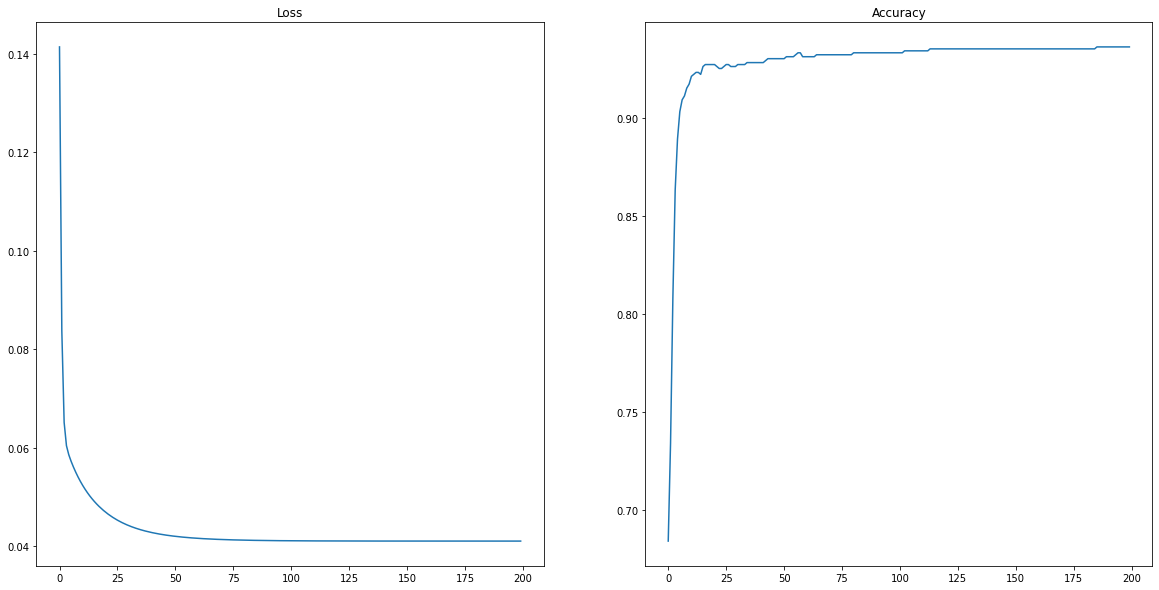

In [16]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

# Test with non informative intervals

In [17]:
df2 = df.copy()
df2["interval"] = [[0, 1] for _ in range(len(df))]
df2.head()

,X1,X2,z,interval,label,p_hat,p,loss
0,3.119353,7.100552,B,"[0, 1]",0,0.135567,0.200000,0.015801
1,-3.850261,-4.934919,A,"[0, 1]",1,0.791774,0.791774,0.000000
2,-4.214494,-7.396423,A,"[0, 1]",1,0.876670,0.850000,0.003106
3,3.197394,4.783222,B,"[0, 1]",0,0.218552,0.218552,0.000000
4,-4.296943,-4.839382,A,"[0, 1]",1,0.789656,0.789656,0.000000


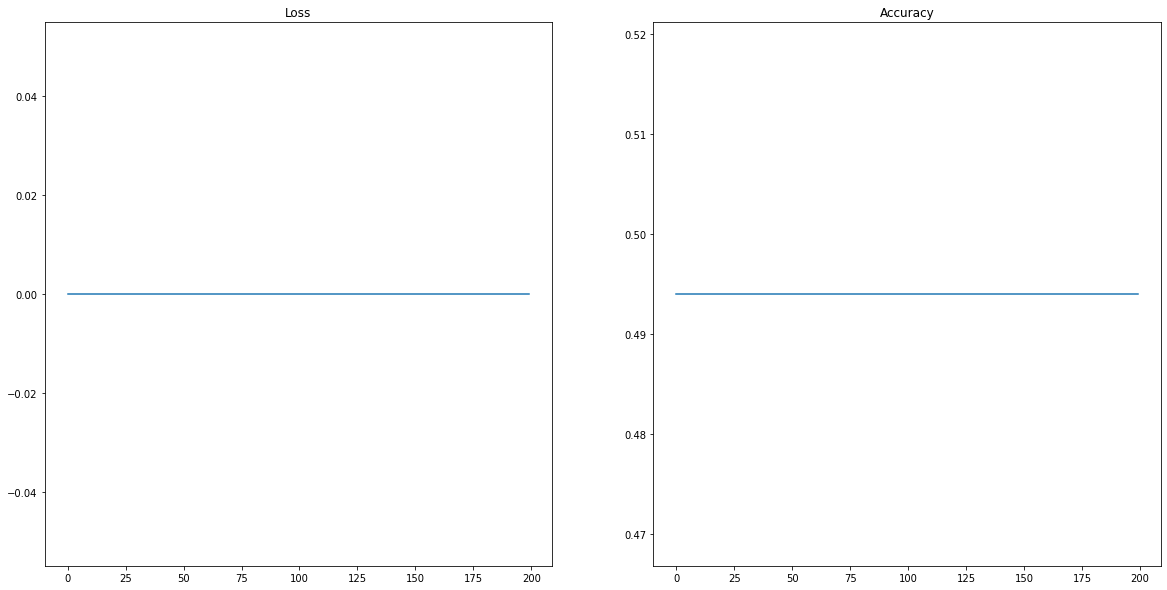

In [18]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
test.fit(x_train=df2[["X1", "X2"]], y_train=df2["interval"], informative=False)

_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

# Test with hard labels

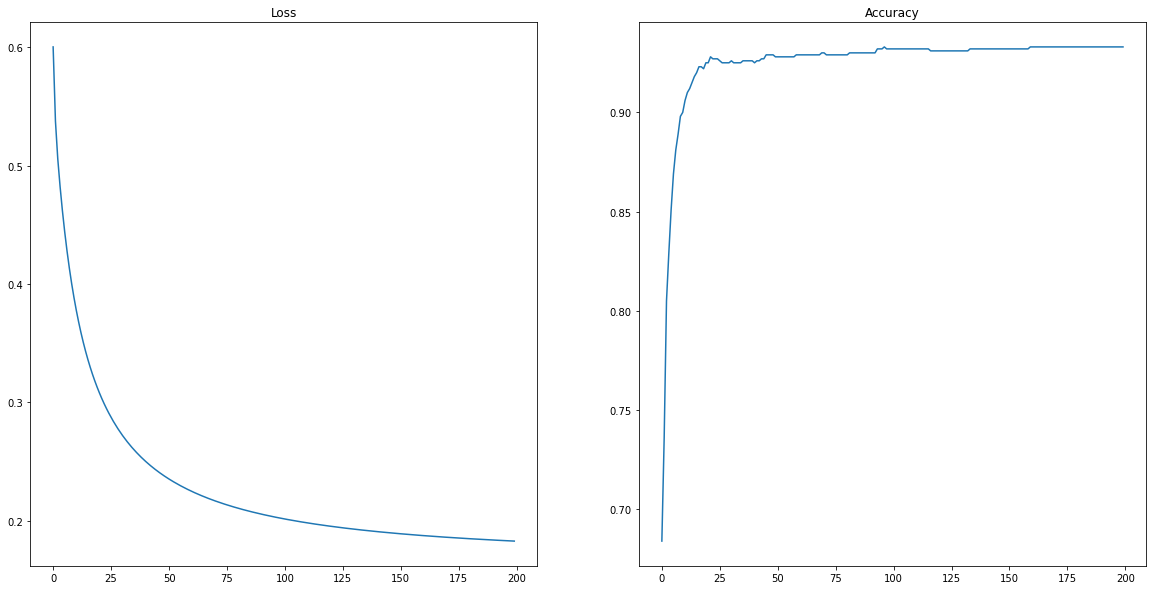

In [19]:
df3 = df.copy()
df3["interval"] = df3["label"].apply(lambda x: [x, x])
                                                       
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
test.fit(x_train=df3[["X1", "X2"]], y_train=df3["interval"])

_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

# Comparison with sklearn.linear_model.LogisticRegression

## Using hard labels

In [20]:
df3.head()

,X1,X2,z,interval,label,p_hat,p,loss
0,3.119353,7.100552,B,"[0, 0]",0,0.135567,0.200000,0.015801
1,-3.850261,-4.934919,A,"[1, 1]",1,0.791774,0.791774,0.000000
2,-4.214494,-7.396423,A,"[1, 1]",1,0.876670,0.850000,0.003106
3,3.197394,4.783222,B,"[0, 0]",0,0.218552,0.218552,0.000000
4,-4.296943,-4.839382,A,"[1, 1]",1,0.789656,0.789656,0.000000


In [21]:
lr = LogisticRegression(max_iter=200)
lr.fit(df3[["X1", "X2"]], df3["label"])
pred = lr.predict(df3[["X1", "X2"]])
accuracy_score(df3["label"], pred)

0.936

In [22]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
test.fit(x_train=df3[["X1", "X2"]], y_train=df3["interval"])
test.accuracies[len(test.accuracies)-1]

0.933

## Using intervals

In [23]:
df.head()

,X1,X2,z,interval,label,p_hat,p,loss
0,3.119353,7.100552,B,"[0.2, 0.43]",0,0.135567,0.200000,0.015801
1,-3.850261,-4.934919,A,"[0.61, 0.8]",1,0.791774,0.791774,0.000000
2,-4.214494,-7.396423,A,"[0.8, 0.85]",1,0.876670,0.850000,0.003106
3,3.197394,4.783222,B,"[0.09, 0.48]",0,0.218552,0.218552,0.000000
4,-4.296943,-4.839382,A,"[0.55, 0.92]",1,0.789656,0.789656,0.000000


In [24]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
test.fit(x_train=df[["X1", "X2"]], y_train=df["interval"])
test.accuracies[len(test.accuracies)-1]

0.936

# Test on another dataset

In [25]:
titanic = pd.read_csv("../data/titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The objective here is not to have the best model but just to see if the performance of our custom logistic regression are quite similar to the sklearn's one. We just will use the variables "Pclass", "Sex" (dummy), "Age" and "Fare"

In [26]:
titanic_df = titanic[["Pclass", "Sex", "Age", "Fare"]]
titanic_df = pd.get_dummies(titanic_df)
scaler = StandardScaler()
columns = titanic_df.columns
titanic_df = pd.DataFrame(scaler.fit_transform(titanic_df), columns=columns)
titanic_df["Survived"] = titanic["Survived"]
titanic_df.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Survived
0,0.827377,-0.530377,-0.502445,-0.737695,0.737695,0
1,-1.566107,0.571831,0.786845,1.355574,-1.355574,1
2,0.827377,-0.254825,-0.488854,1.355574,-1.355574,1
3,-1.566107,0.365167,0.420730,1.355574,-1.355574,1
4,0.827377,0.365167,-0.486337,-0.737695,0.737695,0


In [27]:
titanic_df.corr()

,Pclass,Age,Fare,Sex_female,Sex_male,Survived
Pclass,1.000000,-0.369226,-0.549500,-0.131900,0.131900,-0.338481
Age,-0.369226,1.000000,0.096067,-0.093254,0.093254,-0.077221
Fare,-0.549500,0.096067,1.000000,0.182333,-0.182333,0.257307
Sex_female,-0.131900,-0.093254,0.182333,1.000000,-1.000000,0.543351
Sex_male,0.131900,0.093254,-0.182333,-1.000000,1.000000,-0.543351
Survived,-0.338481,-0.077221,0.257307,0.543351,-0.543351,1.000000


In [28]:
def transform_to_interval(variable: int) -> np.ndarray:
    """
    Transform a hard label into an interval of probabilities.
    If the label is 0, the created interval will be in the range of
    [0, 0.49], else it will be in the range of [0.5, 1]
    
    Args:
        variable (int): variable to transform
    
    Returns:
        (np.ndarray): created interval 
    """
    if variable == 0:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.0,
                    high=0.49,
                    size=(2,)
                ),
                decimals=2
            )
        )
    else:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.5,
                    high=1.0,
                    size=(2,)
                ),
                decimals=2
            )
        )
    return interval

In [29]:
titanic_df["interval"] = titanic_df["Survived"].apply(transform_to_interval)
titanic_df.dropna(inplace=True)
titanic_df.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Survived,interval
0,0.827377,-0.530377,-0.502445,-0.737695,0.737695,0,"[0.36, 0.38]"
1,-1.566107,0.571831,0.786845,1.355574,-1.355574,1,"[0.71, 0.88]"
2,0.827377,-0.254825,-0.488854,1.355574,-1.355574,1,"[0.78, 0.79]"
3,-1.566107,0.365167,0.420730,1.355574,-1.355574,1,"[0.73, 0.82]"
4,0.827377,0.365167,-0.486337,-0.737695,0.737695,0,"[0.17, 0.41]"


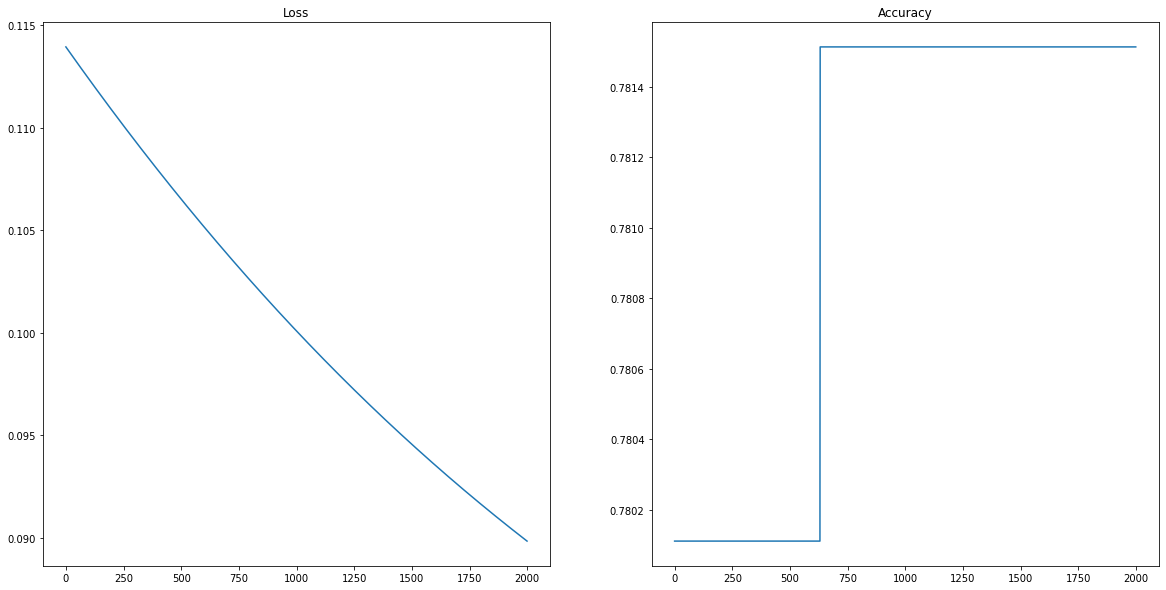

In [30]:
test = CustomLogisticRegression(number_iteration=2000, learning_rate=0.000001)
test.fit(x_train=titanic_df[["Pclass", "Age", "Fare", "Sex_female", "Sex_male"]], y_train=titanic_df["interval"])
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

In [31]:
lr = LogisticRegression(max_iter=200)
lr.fit(titanic_df[["Pclass", "Age", "Fare", "Sex_female", "Sex_male"]], titanic_df["Survived"])
pred = lr.predict(titanic_df[["Pclass", "Age", "Fare", "Sex_female", "Sex_male"]])
accuracy_score(titanic_df["Survived"], pred)

0.7927170868347339

In [32]:
titanic_df["hard_intervals"] = titanic_df["Survived"].apply(lambda x: [x, x])
titanic_df.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Survived,interval,hard_intervals
0,0.827377,-0.530377,-0.502445,-0.737695,0.737695,0,"[0.36, 0.38]","[0, 0]"
1,-1.566107,0.571831,0.786845,1.355574,-1.355574,1,"[0.71, 0.88]","[1, 1]"
2,0.827377,-0.254825,-0.488854,1.355574,-1.355574,1,"[0.78, 0.79]","[1, 1]"
3,-1.566107,0.365167,0.420730,1.355574,-1.355574,1,"[0.73, 0.82]","[1, 1]"
4,0.827377,0.365167,-0.486337,-0.737695,0.737695,0,"[0.17, 0.41]","[0, 0]"


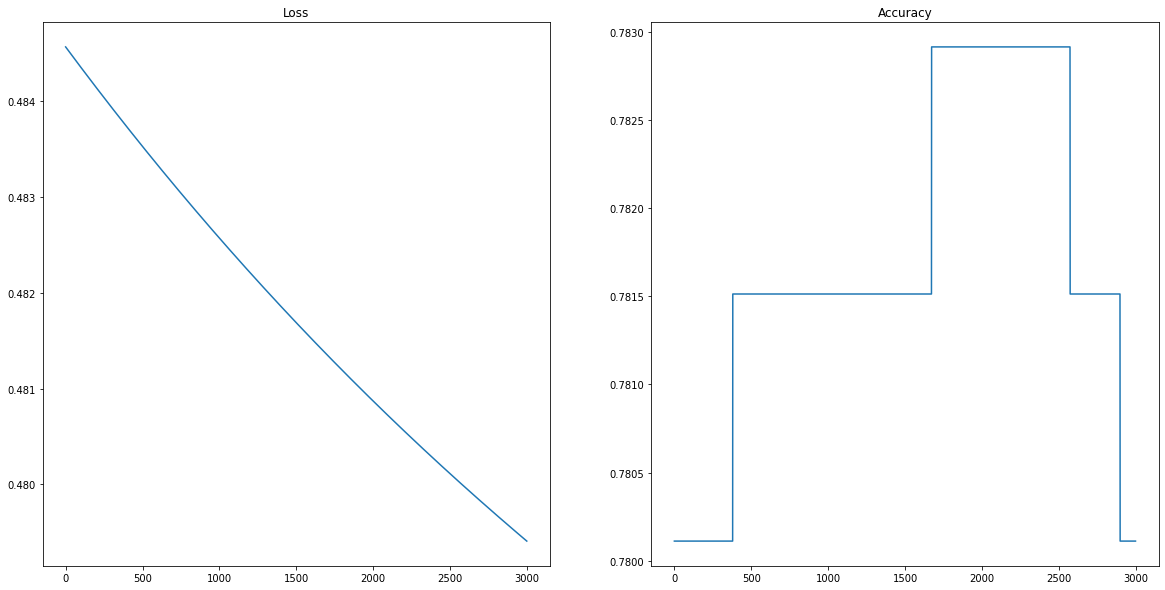

In [33]:
test = CustomLogisticRegression(number_iteration=3000, learning_rate=0.000001)
test.fit(x_train=titanic_df[["Pclass", "Age", "Fare", "Sex_female", "Sex_male"]], y_train=titanic_df["hard_intervals"])
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()

In [34]:
titanic_df["non_informative"] = [[0, 1] for _ in range(len(titanic_df))]
titanic_df.head()

,Pclass,Age,Fare,Sex_female,Sex_male,Survived,interval,hard_intervals,non_informative
0,0.827377,-0.530377,-0.502445,-0.737695,0.737695,0,"[0.36, 0.38]","[0, 0]","[0, 1]"
1,-1.566107,0.571831,0.786845,1.355574,-1.355574,1,"[0.71, 0.88]","[1, 1]","[0, 1]"
2,0.827377,-0.254825,-0.488854,1.355574,-1.355574,1,"[0.78, 0.79]","[1, 1]","[0, 1]"
3,-1.566107,0.365167,0.420730,1.355574,-1.355574,1,"[0.73, 0.82]","[1, 1]","[0, 1]"
4,0.827377,0.365167,-0.486337,-0.737695,0.737695,0,"[0.17, 0.41]","[0, 0]","[0, 1]"


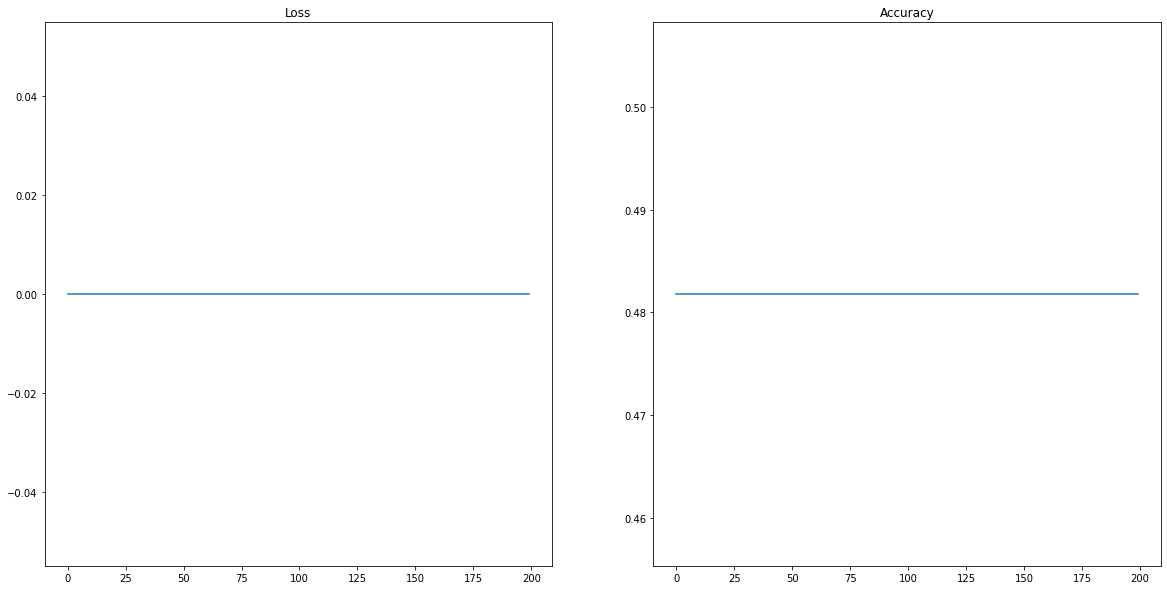

In [35]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.000005)
test.fit(x_train=titanic_df[["Pclass", "Age", "Fare", "Sex_female", "Sex_male"]], y_train=titanic_df["non_informative"], informative=False)
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=test.losses.keys(), y=test.losses.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()